In [1]:
import numpy as np 
from pandas import Series, DataFrame
import pandas as pd
import copy
from astropy import table
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import neighbors, neural_network, preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
catalogs = ['CLASSIC','FARMER']
cat_classic = table.Table.read(r'C:\Users\Sarah\IAstro Intership 2023\Catalogue\COSMOS2020_CLASSIC_R1_v2.2_p3.fits'.format(catalogs[0],format='fits',hdu=1))
cat_farmer = table.Table.read(r'D:\Estágio IA\data\COSMOS2020_{}_R1_v2.2_p3.fits'.format(catalogs[1],format='fits',hdu=1))                              

In [3]:
cat_classic = cat_classic[cat_classic['FLAG_COMBINED']==0]
cat_classic = cat_classic[cat_classic['lp_type'] == 0]

cat_classic[[0,-1]]

ID,ALPHA_J2000,DELTA_J2000,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,FLUX_RADIUS,KRON_RADIUS,FLAG_HSC,FLAG_SUPCAM,FLAG_UVISTA,FLAG_UDEEP,FLAG_COMBINED,EBV_MW,CFHT_u_FLUX_APER2,CFHT_u_FLUXERR_APER2,CFHT_u_FLUX_APER3,CFHT_u_FLUXERR_APER3,CFHT_u_FLUX_AUTO,CFHT_u_FLUXERR_AUTO,CFHT_u_MAG_APER2,CFHT_u_MAGERR_APER2,CFHT_u_MAG_APER3,CFHT_u_MAGERR_APER3,CFHT_u_MAG_AUTO,CFHT_u_MAGERR_AUTO,CFHT_u_MAG_ISO,CFHT_u_MAGERR_ISO,CFHT_u_FLAGS,CFHT_u_IMAFLAGS_ISO,CFHT_ustar_FLUX_APER2,CFHT_ustar_FLUXERR_APER2,CFHT_ustar_FLUX_APER3,CFHT_ustar_FLUXERR_APER3,CFHT_ustar_FLUX_AUTO,CFHT_ustar_FLUXERR_AUTO,CFHT_ustar_MAG_APER2,CFHT_ustar_MAGERR_APER2,CFHT_ustar_MAG_APER3,CFHT_ustar_MAGERR_APER3,CFHT_ustar_MAG_AUTO,CFHT_ustar_MAGERR_AUTO,CFHT_ustar_MAG_ISO,CFHT_ustar_MAGERR_ISO,CFHT_ustar_FLAGS,CFHT_ustar_IMAFLAGS_ISO,HSC_g_FLUX_APER2,HSC_g_FLUXERR_APER2,HSC_g_FLUX_APER3,HSC_g_FLUXERR_APER3,HSC_g_FLUX_AUTO,HSC_g_FLUXERR_AUTO,HSC_g_MAG_APER2,HSC_g_MAGERR_APER2,HSC_g_MAG_APER3,HSC_g_MAGERR_APER3,HSC_g_MAG_AUTO,HSC_g_MAGERR_AUTO,HSC_g_MAG_ISO,HSC_g_MAGERR_ISO,HSC_g_FLAGS,HSC_g_IMAFLAGS_ISO,HSC_r_FLUX_APER2,HSC_r_FLUXERR_APER2,HSC_r_FLUX_APER3,HSC_r_FLUXERR_APER3,HSC_r_FLUX_AUTO,HSC_r_FLUXERR_AUTO,HSC_r_MAG_APER2,HSC_r_MAGERR_APER2,HSC_r_MAG_APER3,HSC_r_MAGERR_APER3,HSC_r_MAG_AUTO,HSC_r_MAGERR_AUTO,HSC_r_MAG_ISO,HSC_r_MAGERR_ISO,HSC_r_FLAGS,HSC_r_IMAFLAGS_ISO,HSC_i_FLUX_APER2,HSC_i_FLUXERR_APER2,HSC_i_FLUX_APER3,HSC_i_FLUXERR_APER3,HSC_i_FLUX_AUTO,HSC_i_FLUXERR_AUTO,HSC_i_MAG_APER2,HSC_i_MAGERR_APER2,HSC_i_MAG_APER3,HSC_i_MAGERR_APER3,HSC_i_MAG_AUTO,HSC_i_MAGERR_AUTO,HSC_i_MAG_ISO,HSC_i_MAGERR_ISO,HSC_i_FLAGS,HSC_i_IMAFLAGS_ISO,HSC_z_FLUX_APER2,HSC_z_FLUXERR_APER2,HSC_z_FLUX_APER3,HSC_z_FLUXERR_APER3,HSC_z_FLUX_AUTO,HSC_z_FLUXERR_AUTO,HSC_z_MAG_APER2,HSC_z_MAGERR_APER2,HSC_z_MAG_APER3,HSC_z_MAGERR_APER3,HSC_z_MAG_AUTO,HSC_z_MAGERR_AUTO,HSC_z_MAG_ISO,HSC_z_MAGERR_ISO,HSC_z_FLAGS,HSC_z_IMAFLAGS_ISO,HSC_y_FLUX_APER2,HSC_y_FLUXERR_APER2,HSC_y_FLUX_APER3,HSC_y_FLUXERR_APER3,HSC_y_FLUX_AUTO,HSC_y_FLUXERR_AUTO,HSC_y_MAG_APER2,HSC_y_MAGERR_APER2,HSC_y_MAG_APER3,HSC_y_MAGERR_APER3,HSC_y_MAG_AUTO,HSC_y_MAGERR_AUTO,HSC_y_MAG_ISO,HSC_y_MAGERR_ISO,HSC_y_FLAGS,HSC_y_IMAFLAGS_ISO,UVISTA_Y_FLUX_APER2,UVISTA_Y_FLUXERR_APER2,UVISTA_Y_FLUX_APER3,UVISTA_Y_FLUXERR_APER3,UVISTA_Y_FLUX_AUTO,UVISTA_Y_FLUXERR_AUTO,UVISTA_Y_MAG_APER2,UVISTA_Y_MAGERR_APER2,UVISTA_Y_MAG_APER3,UVISTA_Y_MAGERR_APER3,UVISTA_Y_MAG_AUTO,UVISTA_Y_MAGERR_AUTO,UVISTA_Y_MAG_ISO,UVISTA_Y_MAGERR_ISO,UVISTA_Y_FLAGS,UVISTA_Y_IMAFLAGS_ISO,UVISTA_J_FLUX_APER2,UVISTA_J_FLUXERR_APER2,UVISTA_J_FLUX_APER3,UVISTA_J_FLUXERR_APER3,UVISTA_J_FLUX_AUTO,UVISTA_J_FLUXERR_AUTO,UVISTA_J_MAG_APER2,UVISTA_J_MAGERR_APER2,UVISTA_J_MAG_APER3,UVISTA_J_MAGERR_APER3,UVISTA_J_MAG_AUTO,UVISTA_J_MAGERR_AUTO,UVISTA_J_MAG_ISO,UVISTA_J_MAGERR_ISO,UVISTA_J_FLAGS,UVISTA_J_IMAFLAGS_ISO,UVISTA_H_FLUX_APER2,UVISTA_H_FLUXERR_APER2,UVISTA_H_FLUX_APER3,UVISTA_H_FLUXERR_APER3,UVISTA_H_FLUX_AUTO,UVISTA_H_FLUXERR_AUTO,UVISTA_H_MAG_APER2,UVISTA_H_MAGERR_APER2,UVISTA_H_MAG_APER3,UVISTA_H_MAGERR_APER3,UVISTA_H_MAG_AUTO,UVISTA_H_MAGERR_AUTO,UVISTA_H_MAG_ISO,UVISTA_H_MAGERR_ISO,UVISTA_H_FLAGS,UVISTA_H_IMAFLAGS_ISO,UVISTA_Ks_FLUX_APER2,UVISTA_Ks_FLUXERR_APER2,UVISTA_Ks_FLUX_APER3,UVISTA_Ks_FLUXERR_APER3,UVISTA_Ks_FLUX_AUTO,UVISTA_Ks_FLUXERR_AUTO,UVISTA_Ks_MAG_APER2,UVISTA_Ks_MAGERR_APER2,UVISTA_Ks_MAG_APER3,UVISTA_Ks_MAGERR_APER3,UVISTA_Ks_MAG_AUTO,UVISTA_Ks_MAGERR_AUTO,UVISTA_Ks_MAG_ISO,UVISTA_Ks_MAGERR_ISO,UVISTA_Ks_FLAGS,UVISTA_Ks_IMAFLAGS_ISO,SC_IB427_FLUX_APER2,SC_IB427_FLUXERR_APER2,SC_IB427_FLUX_APER3,SC_IB427_FLUXERR_APER3,SC_IB427_FLUX_AUTO,SC_IB427_FLUXERR_AUTO,SC_IB427_MAG_APER2,SC_IB427_MAGERR_APER2,SC_IB427_MAG_APER3,SC_IB427_MAGERR_APER3,SC_IB427_MAG_AUTO,SC_IB427_MAGERR_AUTO,SC_IB427_MAG_ISO,SC_IB427_MAGERR_ISO,SC_IB427_FLAGS,SC_IB427_IMAFLAGS_ISO,SC_IB464_FLUX_APER2,SC_IB464_FLUXERR_APER2,SC_IB464_FLUX_APER3,SC_IB464_FLUXERR_APER3,SC_IB464_FLUX_AUTO,SC_IB464_FLUXERR_AUTO,SC_IB464_MAG_APER2,SC_IB464_MAGERR_APER2,SC_IB464_MAG_APER3,SC_IB

In [4]:
cat_farmer = cat_farmer[cat_farmer['FLAG_COMBINED']==0]
cat_farmer = cat_farmer[cat_farmer['lp_type'] == 0]

cat_farmer[[0,-1]]

ID,ALPHA_J2000,DELTA_J2000,X_MODEL,Y_MODEL,ERRX_MODEL,ERRY_MODEL,ALPHA_DETECTION,DELTA_DETECTION,FARMER_ID,GROUP_ID,N_GROUP,MODEL_FLAG,SOLUTION_MODEL,FLAG_HSC,FLAG_SUPCAM,FLAG_UDEEP,FLAG_UVISTA,FLAG_COMBINED,EBV_MW,CFHT_u_FLUX,CFHT_u_FLUXERR,CFHT_u_MAG,CFHT_u_MAGERR,CFHT_u_CHISQ,CFHT_u_DRIFT,CFHT_u_VALID,CFHT_ustar_FLUX,CFHT_ustar_FLUXERR,CFHT_ustar_MAG,CFHT_ustar_MAGERR,CFHT_ustar_CHISQ,CFHT_ustar_DRIFT,CFHT_ustar_VALID,HSC_g_FLUX,HSC_g_FLUXERR,HSC_g_MAG,HSC_g_MAGERR,HSC_g_CHISQ,HSC_g_DRIFT,HSC_g_VALID,HSC_r_FLUX,HSC_r_FLUXERR,HSC_r_MAG,HSC_r_MAGERR,HSC_r_CHISQ,HSC_r_DRIFT,HSC_r_VALID,HSC_i_FLUX,HSC_i_FLUXERR,HSC_i_MAG,HSC_i_MAGERR,HSC_i_CHISQ,HSC_i_DRIFT,HSC_i_VALID,HSC_z_FLUX,HSC_z_FLUXERR,HSC_z_MAG,HSC_z_MAGERR,HSC_z_CHISQ,HSC_z_DRIFT,HSC_z_VALID,HSC_y_FLUX,HSC_y_FLUXERR,HSC_y_MAG,HSC_y_MAGERR,HSC_y_CHISQ,HSC_y_DRIFT,HSC_y_VALID,UVISTA_Y_FLUX,UVISTA_Y_FLUXERR,UVISTA_Y_MAG,UVISTA_Y_MAGERR,UVISTA_Y_CHISQ,UVISTA_Y_DRIFT,UVISTA_Y_VALID,UVISTA_J_FLUX,UVISTA_J_FLUXERR,UVISTA_J_MAG,UVISTA_J_MAGERR,UVISTA_J_CHISQ,UVISTA_J_DRIFT,UVISTA_J_VALID,UVISTA_H_FLUX,UVISTA_H_FLUXERR,UVISTA_H_MAG,UVISTA_H_MAGERR,UVISTA_H_CHISQ,UVISTA_H_DRIFT,UVISTA_H_VALID,UVISTA_Ks_FLUX,UVISTA_Ks_FLUXERR,UVISTA_Ks_MAG,UVISTA_Ks_MAGERR,UVISTA_Ks_CHISQ,UVISTA_Ks_DRIFT,UVISTA_Ks_VALID,UVISTA_NB118_FLUX,UVISTA_NB118_FLUXERR,UVISTA_NB118_MAG,UVISTA_NB118_MAGERR,UVISTA_NB118_CHISQ,UVISTA_NB118_DRIFT,UVISTA_NB118_VALID,SC_IB427_FLUX,SC_IB427_FLUXERR,SC_IB427_MAG,SC_IB427_MAGERR,SC_IB427_CHISQ,SC_IB427_DRIFT,SC_IB427_VALID,SC_IB464_FLUX,SC_IB464_FLUXERR,SC_IB464_MAG,SC_IB464_MAGERR,SC_IB464_CHISQ,SC_IB464_DRIFT,SC_IB464_VALID,SC_IA484_FLUX,SC_IA484_FLUXERR,SC_IA484_MAG,SC_IA484_MAGERR,SC_IA484_CHISQ,SC_IA484_DRIFT,SC_IA484_VALID,SC_IB505_FLUX,SC_IB505_FLUXERR,SC_IB505_MAG,SC_IB505_MAGERR,SC_IB505_CHISQ,SC_IB505_DRIFT,SC_IB505_VALID,SC_IA527_FLUX,SC_IA527_FLUXERR,SC_IA527_MAG,SC_IA527_MAGERR,SC_IA527_CHISQ,SC_IA527_DRIFT,SC_IA527_VALID,SC_IB574_FLUX,SC_IB574_FLUXERR,SC_IB574_MAG,SC_IB574_MAGERR,SC_IB574_CHISQ,SC_IB574_DRIFT,SC_IB574_VALID,SC_IA624_FLUX,SC_IA624_FLUXERR,SC_IA624_MAG,SC_IA624_MAGERR,SC_IA624_CHISQ,SC_IA624_DRIFT,SC_IA624_VALID,SC_IA679_FLUX,SC_IA679_FLUXERR,SC_IA679_MAG,SC_IA679_MAGERR,SC_IA679_CHISQ,SC_IA679_DRIFT,SC_IA679_VALID,SC_IB709_FLUX,SC_IB709_FLUXERR,SC_IB709_MAG,SC_IB709_MAGERR,SC_IB709_CHISQ,SC_IB709_DRIFT,SC_IB709_VALID,SC_IA738_FLUX,SC_IA738_FLUXERR,SC_IA738_MAG,SC_IA738_MAGERR,SC_IA738_CHISQ,SC_IA738_DRIFT,SC_IA738_VALID,SC_IA767_FLUX,SC_IA767_FLUXERR,SC_IA767_MAG,SC_IA767_MAGERR,SC_IA767_CHISQ,SC_IA767_DRIFT,SC_IA767_VALID,SC_IB827_FLUX,SC_IB827_FLUXERR,SC_IB827_MAG,SC_IB827_MAGERR,SC_IB827_CHISQ,SC_IB827_DRIFT,SC_IB827_VALID,SC_NB711_FLUX,SC_NB711_FLUXERR,SC_NB711_MAG,SC_NB711_MAGERR,SC_NB711_CHISQ,SC_NB711_DRIFT,SC_NB711_VALID,SC_NB816_FLUX,SC_NB816_FLUXERR,SC_NB816_MAG,SC_NB816_MAGERR,SC_NB816_CHISQ,SC_NB816_DRIFT,SC_NB816_VALID,IRAC_CH1_FLUX,IRAC_CH1_FLUXERR,IRAC_CH1_MAG,IRAC_CH1_MAGERR,IRAC_CH1_CHISQ,IRAC_CH1_DRIFT,IRAC_CH1_VALID,IRAC_CH2_FLUX,IRAC_CH2_FLUXERR,IRAC_CH2_MAG,IRAC_CH2_MAGERR,IRAC_CH2_CHISQ,IRAC_CH2_DRIFT,IRAC_CH2_VALID,IRAC_CH3_FLUX,IRAC_CH3_FLUXERR,IRAC_CH3_MAG,IRAC_CH3_MAGERR,IRAC_CH3_CHISQ,IRAC_CH3_DRIFT,IRAC_CH3_VALID,IRAC_CH4_FLUX,IRAC_CH4_FLUXERR,IRAC_CH4_MAG,IRAC_CH4_MAGERR,IRAC_CH4_CHISQ,IRAC_CH4_DRIFT,IRAC_CH4_VALID,ID_GALEX,GALEX_NUV_FLUX,GALEX_NUV_FLUXERR,GALEX_NUV_MAG,GALEX_NUV_MAGERR,GALEX_FUV_FLUX,GALEX_FUV_FLUXERR,GALEX_FUV_MAG,GALEX_FUV_MAGERR,ID_COSMOS2015,SPLASH_CH1_FLUX,SPLASH_CH1_FLUXERR,SPLASH_CH1_MAG,SPLASH_CH1_MAGERR,SPLASH_CH2_FLUX,SPLASH_CH2_FLUXERR,SPLASH_CH2_MAG,SPLASH_CH2_MAGERR,SPLASH_CH3_FLUX,SPLASH_CH3_FLUXERR,SPLASH_CH3_MAG,SPLASH_CH3_MAGERR,SPLASH_CH4_FLUX,SPLASH_CH4_FLUXERR,SPLASH_CH4_MAG,SPLASH_CH4_MAGERR,ID_ACS,ACS_F814W_MAG,ACS_F814W_MAGERR,ACS_F814W_FLUX,ACS_F814W_FLUXERR,ACS_A_WORLD,ACS_B_WORLD,ACS_THETA_WORLD,ACS_FWHM_WORLD,ACS_MU_MAX,ACS_MU_CLASS,ID_CHANDRA,ID_CLASSIC,lp_zBEST,lp_type,lp_zPDF,lp_zPDF_l68,lp_zPDF_u68,lp_zMinChi2,lp_chi2_best,lp_zp_2,lp_chi2_2,lp_NbFilt,lp_zq,lp

In [100]:
# flux/mag columns
#-------------------------------------------------------
#predefinido atualmente para apenas magnitudes, sem erros
#--------------------------------------------------------

columns_classic = []
classic_without_APER3 = []
columns_farmer = []
lst_diff = []

for column in cat_classic.colnames:
    
    #if 'FLUX_APER3' in column : #or 'FLUXERR_APER3' in column
        #columns_classic.append(column)
        
    if 'MAG_APER3' in column : #or 'MAGERR_APER3' in column
        columns_classic.append(column)
        

classic_without_APER3 = [s.replace('_APER3', '') for s in columns_classic]
        
for column in  cat_farmer.colnames:    
    if 'MAG' in column: #'FLUX' in column or
        if not 'ERR' in column:
            columns_farmer.append(column)
            if column not in classic_without_APER3:
                lst_diff.append(column)

for column in classic_without_APER3:
    if column not in columns_farmer and column not in lst_diff:
        lst_diff.append(column)

              
print('CLASSIC: {}'.format(columns_classic))
print('--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('CLASSIC: {}'.format(classic_without_APER3))       
print('--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('FARMER: {}'.format(columns_farmer))
print('--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('There are only in one of the two catalogs: {}'.format(lst_diff)) 

CLASSIC: ['CFHT_u_MAG_APER3', 'CFHT_ustar_MAG_APER3', 'HSC_g_MAG_APER3', 'HSC_r_MAG_APER3', 'HSC_i_MAG_APER3', 'HSC_z_MAG_APER3', 'HSC_y_MAG_APER3', 'UVISTA_Y_MAG_APER3', 'UVISTA_J_MAG_APER3', 'UVISTA_H_MAG_APER3', 'UVISTA_Ks_MAG_APER3', 'SC_IB427_MAG_APER3', 'SC_IB464_MAG_APER3', 'SC_IA484_MAG_APER3', 'SC_IB505_MAG_APER3', 'SC_IA527_MAG_APER3', 'SC_IB574_MAG_APER3', 'SC_IA624_MAG_APER3', 'SC_IA679_MAG_APER3', 'SC_IB709_MAG_APER3', 'SC_IA738_MAG_APER3', 'SC_IA767_MAG_APER3', 'SC_IB827_MAG_APER3', 'SC_NB711_MAG_APER3', 'SC_NB816_MAG_APER3', 'UVISTA_NB118_MAG_APER3', 'SC_B_MAG_APER3', 'SC_gp_MAG_APER3', 'SC_V_MAG_APER3', 'SC_rp_MAG_APER3', 'SC_ip_MAG_APER3', 'SC_zp_MAG_APER3', 'SC_zpp_MAG_APER3']
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
CLASSIC: ['CFHT_u_MAG', 'CFHT_ustar_MAG',

In [101]:
catalog_classic = cat_classic.copy()
catalog_farmer = cat_farmer.copy()

In [102]:
# columns 
catalog_classic.keep_columns(columns_classic)
catalog_farmer.keep_columns(columns_farmer)

#to pandas
catalog_classic = catalog_classic.to_pandas()
catalog_farmer = catalog_farmer.to_pandas()

In [103]:
catalog_classic.columns = classic_without_APER3
catalog_classic.iloc[[0,-1]]

,CFHT_u_MAG,CFHT_ustar_MAG,HSC_g_MAG,HSC_r_MAG,HSC_i_MAG,HSC_z_MAG,HSC_y_MAG,UVISTA_Y_MAG,UVISTA_J_MAG,UVISTA_H_MAG,...,SC_NB711_MAG,SC_NB816_MAG,UVISTA_NB118_MAG,SC_B_MAG,SC_gp_MAG,SC_V_MAG,SC_rp_MAG,SC_ip_MAG,SC_zp_MAG,SC_zpp_MAG
0,27.180681,27.173019,27.739058,27.398775,26.934248,25.924570,26.934841,NaN,23.521275,26.242453,...,26.270699,27.049919,NaN,27.258339,NaN,26.968216,26.610229,26.727140,26.465061,25.765558
711917,21.324522,21.310570,20.505676,19.710558,19.388117,19.092119,19.061224,19.078358,18.816261,18.645008,...,19.574253,19.449543,NaN,21.038465,20.664837,20.008242,19.772598,19.446918,19.071476,19.081081


In [104]:
catalog_farmer.iloc[[0,-1]]

,CFHT_u_MAG,CFHT_ustar_MAG,HSC_g_MAG,HSC_r_MAG,HSC_i_MAG,HSC_z_MAG,HSC_y_MAG,UVISTA_Y_MAG,UVISTA_J_MAG,UVISTA_H_MAG,...,IRAC_CH2_MAG,IRAC_CH3_MAG,IRAC_CH4_MAG,GALEX_NUV_MAG,GALEX_FUV_MAG,SPLASH_CH1_MAG,SPLASH_CH2_MAG,SPLASH_CH3_MAG,SPLASH_CH4_MAG,ACS_F814W_MAG
0,26.089124,26.013149,26.002327,25.887478,25.977980,25.866000,25.569493,25.515383,25.049719,24.972339,...,25.122357,23.651256,NaN,NaN,26.256296,25.202616,25.135260,NaN,NaN,25.791597
709086,25.300035,NaN,25.165601,NaN,24.595842,24.562475,NaN,25.162759,NaN,NaN,...,NaN,22.681312,NaN,26.798052,NaN,23.441175,23.918068,22.525866,NaN,24.327291


In [105]:
#normalize the data
scaler = MinMaxScaler()
catalog_farmer_normalized = pd.DataFrame(scaler.fit_transform(catalog_farmer), columns=catalog_farmer.columns)
catalog_classic_normalized = pd.DataFrame(scaler.fit_transform(catalog_classic), columns=catalog_classic.columns)

In [106]:
catalog_classic_normalized.iloc[[0,-1]]

,CFHT_u_MAG,CFHT_ustar_MAG,HSC_g_MAG,HSC_r_MAG,HSC_i_MAG,HSC_z_MAG,HSC_y_MAG,UVISTA_Y_MAG,UVISTA_J_MAG,UVISTA_H_MAG,...,SC_NB711_MAG,SC_NB816_MAG,UVISTA_NB118_MAG,SC_B_MAG,SC_gp_MAG,SC_V_MAG,SC_rp_MAG,SC_ip_MAG,SC_zp_MAG,SC_zpp_MAG
0,0.324751,0.339639,0.431490,0.414267,0.441019,0.445061,0.455373,NaN,0.262218,0.399084,...,0.363264,0.414980,NaN,0.373057,NaN,0.343667,0.407893,0.422420,0.397906,0.385600
711917,0.051721,0.057229,0.061509,0.039334,0.048703,0.053676,0.054917,0.045876,0.053585,0.055270,...,0.060132,0.049971,NaN,0.067179,0.062712,0.041666,0.044827,0.049081,0.047914,0.050554


In [107]:
catalog_farmer_normalized.iloc[[0,-1]]

,CFHT_u_MAG,CFHT_ustar_MAG,HSC_g_MAG,HSC_r_MAG,HSC_i_MAG,HSC_z_MAG,HSC_y_MAG,UVISTA_Y_MAG,UVISTA_J_MAG,UVISTA_H_MAG,...,IRAC_CH2_MAG,IRAC_CH3_MAG,IRAC_CH4_MAG,GALEX_NUV_MAG,GALEX_FUV_MAG,SPLASH_CH1_MAG,SPLASH_CH2_MAG,SPLASH_CH3_MAG,SPLASH_CH4_MAG,ACS_F814W_MAG
0,0.505040,0.501073,0.476677,0.472278,0.429303,0.561749,0.519936,0.419706,0.494597,0.480236,...,0.44465,0.405990,NaN,NaN,0.817167,0.410133,0.396664,NaN,NaN,0.506050
709086,0.476774,NaN,0.443698,NaN,0.354926,0.506796,NaN,0.404327,NaN,NaN,...,NaN,0.372906,NaN,0.743722,NaN,0.324582,0.341738,0.444288,NaN,0.419364


In [108]:
data = pd.concat([catalog_classic_normalized, catalog_farmer_normalized])
data

,CFHT_u_MAG,CFHT_ustar_MAG,HSC_g_MAG,HSC_r_MAG,HSC_i_MAG,HSC_z_MAG,HSC_y_MAG,UVISTA_Y_MAG,UVISTA_J_MAG,UVISTA_H_MAG,...,IRAC_CH2_MAG,IRAC_CH3_MAG,IRAC_CH4_MAG,GALEX_NUV_MAG,GALEX_FUV_MAG,SPLASH_CH1_MAG,SPLASH_CH2_MAG,SPLASH_CH3_MAG,SPLASH_CH4_MAG,ACS_F814W_MAG
0,0.324751,0.339639,0.431490,0.414267,0.441019,0.445061,0.455373,NaN,0.262218,0.399084,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.343417,0.314500,0.329312,0.318665,0.364278,0.410640,0.361335,0.324740,0.268106,0.382137,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.282421,0.317069,0.353869,0.346019,0.357772,0.383434,0.337242,NaN,0.275031,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.303748,0.324796,0.380012,0.354616,0.389246,0.446144,0.416582,0.288261,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.301000,0.336421,0.372032,0.369162,0.378269,0.400348,0.346567,0.242934,0.257744,0.288992,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709082,0.507537,NaN,0.449593,0.430011,0.354694,0.501215,0.500285,0.396084,NaN,NaN,...,NaN,NaN,NaN,NaN,0.924766,0.349297,0.352308,NaN,NaN,0.405276
709083,NaN,NaN,0.519541,0.473663,0.383057,0.516225,0.483378,0.368947,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.331423,0.343319,NaN,NaN,0.422256
709084,0.533360,NaN,0.504348,NaN,0.384411,0.542597,NaN,NaN,NaN,NaN,...,NaN,0.384107,NaN,NaN,NaN,0.345431,0.351522,NaN,NaN,0.443571
709085,NaN,NaN,NaN,NaN,0.370039,NaN,NaN,NaN,NaN,NaN,...,NaN,0.422606,NaN,NaN,NaN,0.359274,0.357851,0.478856,NaN,0.426952


-----------------------------------------------------

In [109]:
labels_classic = cat_classic.copy()
labels_farmer = cat_farmer.copy()

In [110]:
# labels : stellar mass, star formation rate, age, dust, vitality, redshift
labels = ['lp_age','lp_dust','lp_mass_best','lp_zBEST','lp_SFR_best']

labels_classic.keep_columns(labels)
labels_farmer.keep_columns(labels)

labels_classic = labels_classic.to_pandas()
labels_farmer = labels_farmer.to_pandas()

#normalize the data
scaler = MinMaxScaler()
labels_classic_normalized = pd.DataFrame(scaler.fit_transform(labels_classic), columns=labels_classic.columns)
labels_farmer_normalized = pd.DataFrame(scaler.fit_transform(labels_farmer), columns=labels_farmer.columns)

In [111]:
labels_classic_normalized.iloc[[0,-1]]

,lp_zBEST,lp_age,lp_dust,lp_mass_best,lp_SFR_best
0,0.126657,0.035429,0.285714,0.804729,0.892704
711917,0.030360,0.120386,0.428571,0.911260,0.935921


In [112]:
labels_farmer_normalized.iloc[[0,-1]]

,lp_zBEST,lp_age,lp_dust,lp_mass_best,lp_SFR_best
0,0.158578,0.035429,0.142857,0.766199,0.910902
709086,0.029782,0.051637,0.000000,0.706138,0.873792


In [168]:
target = pd.concat([labels_classic_normalized, labels_farmer_normalized])
target

,lp_zBEST,lp_age,lp_dust,lp_mass_best,lp_SFR_best
0,0.126657,0.035429,0.285714,0.804729,0.892704
1,0.289864,0.000000,0.142857,0.816649,0.923300
2,0.095304,0.066008,0.000000,0.826807,0.878015
3,0.035116,0.045598,0.000000,0.734462,0.853946
4,0.119844,0.305019,0.142857,0.862372,0.889143
...,...,...,...,...,...
709082,0.031124,0.020927,0.000000,0.717062,0.862016
709083,0.003907,0.922780,0.285714,0.687261,0.756255
709084,0.080791,0.023954,0.000000,0.724588,0.885566
709085,0.007132,0.000000,0.142857,0.607618,0.850786


-------------------------------

# Tentativa: usando lp_mass_best

In [144]:
X = data
y = target['lp_mass_best']

nan_mask = y.isna()

X = X[~nan_mask]
y = y[~nan_mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1765, random_state=42)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

Train: (990571, 44)
Validation: (212309, 44)
Test: (212273, 44)


XGBREGRESSOR(BASE_SCORE=NONE, BOOSTER=NONE, CALLBACKS=NONE,
             COLSAMPLE_BYLEVEL=NONE, COLSAMPLE_BYNODE=NONE,
             COLSAMPLE_BYTREE=0.8, EARLY_STOPPING_ROUNDS=NONE,
             ENABLE_CATEGORICAL=FALSE, EVAL_METRIC=NONE, FEATURE_TYPES=NONE,
             GAMMA=NONE, GPU_ID=NONE, GROW_POLICY=NONE, IMPORTANCE_TYPE=NONE,
             INTERACTION_CONSTRAINTS=NONE, LEARNING_RATE=NONE, MAX_BIN=NONE,
             MAX_CAT_THRESHOLD=NONE, MAX_CAT_TO_ONEHOT=NONE,
             MAX_DELTA_STEP=NONE, MAX_DEPTH=9, MAX_LEAVES=NONE,
             MIN_CHILD_WEIGHT=NONE, MISSING=NAN, MONOTONE_CONSTRAINTS=NONE,
             N_ESTIMATORS=200, N_JOBS=NONE, NTHREAD=-1, NUM_PARALLEL_TREE=NONE,
             PREDICTOR=NONE, ...)


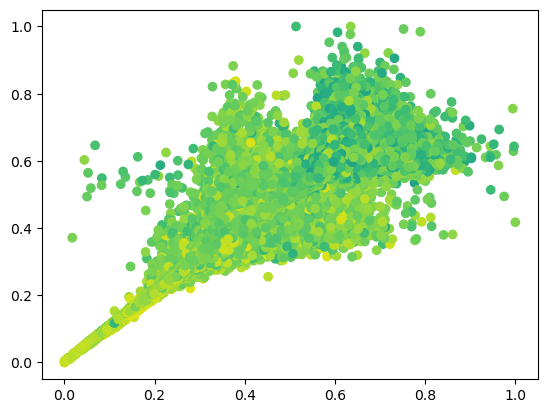

LGBMREGRESSOR(COLSAMPLE_BYTREE=0.9, MAX_DEPTH=12, N_ESTIMATORS=2000, N_JOBS=-1,
              OBJECTIVE='REGRESSION', SUBSAMPLE=0.8)
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11220
[LightGBM] [Info] Number of data points in the train set: 990571, number of used features: 44
[LightGBM] [Info] Start training from score 0.789939
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


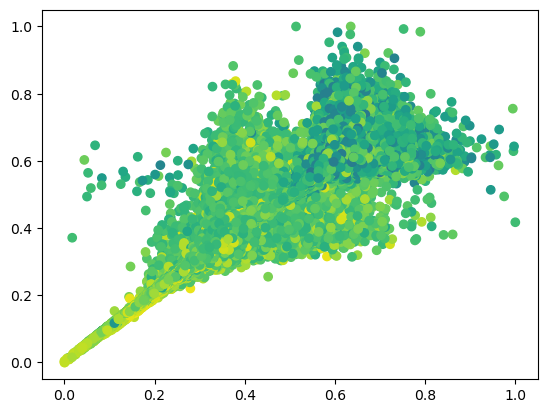

<CATBOOST.CORE.CATBOOSTREGRESSOR OBJECT AT 0X0000024CE413C610>


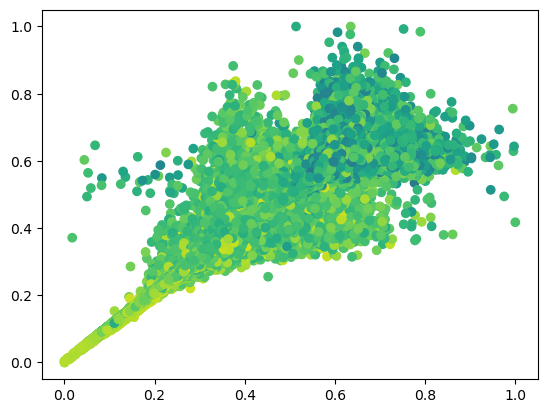

In [146]:
models = [
        XGBRegressor(
        objective='reg:squarederror', 
        n_estimators = 200,
        max_depth = 9,
        tree_method ='gpu_hist',
        nthread = -1,
        subsample = 0.8,
        colsample_bytree = 0.8
    ),
    
        LGBMRegressor(
        objective='regression',  
        n_jobs = -1,
        n_estimators = 2000,
        max_depth = 12,
        subsample = 0.8,
        colsample_bytree = 0.9
    ),
    
        CatBoostRegressor(
        loss_function ='RMSE',  
        logging_level ='Silent',
        n_estimators = 1000,
        max_depth = 11,
        task_type = "GPU"
    )
         ]

for method in models:
    print(str(method).upper())
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("model", method)
    ])

    pred = pipe.fit(X_train, y_train).predict(X_train)
    plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=pred)
    plt.show()

# Série de Tentativas para todos

In [ ]:
X = data
y = target

nan_mask = y.isna().any(axis=1)

X = X[~nan_mask]
y = y[~nan_mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1765, random_state=42)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

XGBREGRESSOR(BASE_SCORE=NONE, BOOSTER=NONE, CALLBACKS=NONE,
             COLSAMPLE_BYLEVEL=NONE, COLSAMPLE_BYNODE=NONE,
             COLSAMPLE_BYTREE=0.8, EARLY_STOPPING_ROUNDS=NONE,
             ENABLE_CATEGORICAL=FALSE, EVAL_METRIC=NONE, FEATURE_TYPES=NONE,
             GAMMA=NONE, GPU_ID=NONE, GROW_POLICY=NONE, IMPORTANCE_TYPE=NONE,
             INTERACTION_CONSTRAINTS=NONE, LEARNING_RATE=NONE, MAX_BIN=NONE,
             MAX_CAT_THRESHOLD=NONE, MAX_CAT_TO_ONEHOT=NONE,
             MAX_DELTA_STEP=NONE, MAX_DEPTH=9, MAX_LEAVES=NONE,
             MIN_CHILD_WEIGHT=NONE, MISSING=NAN, MONOTONE_CONSTRAINTS=NONE,
             N_ESTIMATORS=200, N_JOBS=NONE, NTHREAD=-1, NUM_PARALLEL_TREE=NONE,
             PREDICTOR=NONE, ...)


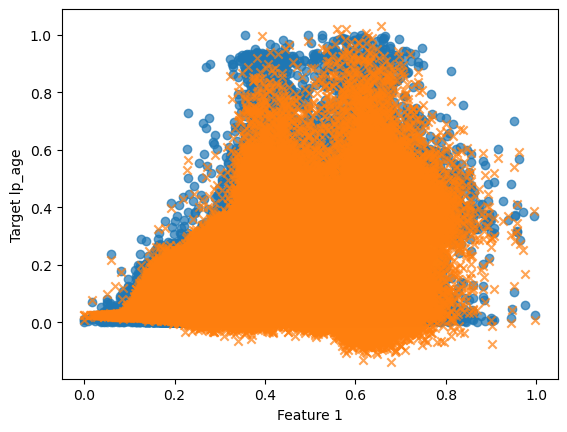

LGBMREGRESSOR(COLSAMPLE_BYTREE=0.9, MAX_DEPTH=12, N_ESTIMATORS=2000, N_JOBS=-1,
              OBJECTIVE='REGRESSION', SUBSAMPLE=0.8)


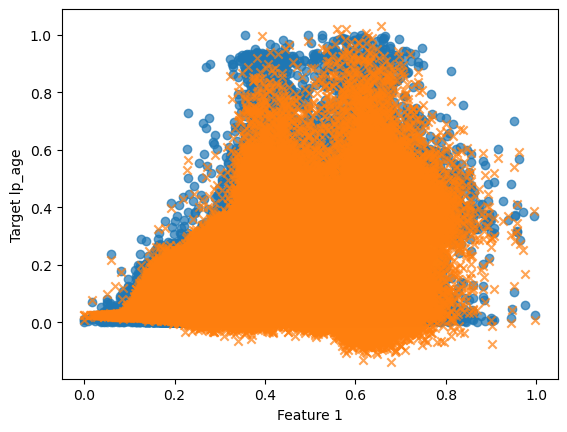

<CATBOOST.CORE.CATBOOSTREGRESSOR OBJECT AT 0X0000024CA4357850>


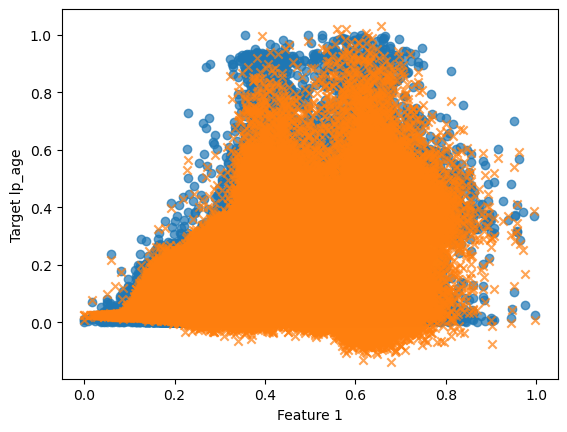

XGBREGRESSOR(BASE_SCORE=NONE, BOOSTER=NONE, CALLBACKS=NONE,
             COLSAMPLE_BYLEVEL=NONE, COLSAMPLE_BYNODE=NONE,
             COLSAMPLE_BYTREE=0.8, EARLY_STOPPING_ROUNDS=NONE,
             ENABLE_CATEGORICAL=FALSE, EVAL_METRIC=NONE, FEATURE_TYPES=NONE,
             GAMMA=NONE, GPU_ID=NONE, GROW_POLICY=NONE, IMPORTANCE_TYPE=NONE,
             INTERACTION_CONSTRAINTS=NONE, LEARNING_RATE=NONE, MAX_BIN=NONE,
             MAX_CAT_THRESHOLD=NONE, MAX_CAT_TO_ONEHOT=NONE,
             MAX_DELTA_STEP=NONE, MAX_DEPTH=9, MAX_LEAVES=NONE,
             MIN_CHILD_WEIGHT=NONE, MISSING=NAN, MONOTONE_CONSTRAINTS=NONE,
             N_ESTIMATORS=200, N_JOBS=NONE, NTHREAD=-1, NUM_PARALLEL_TREE=NONE,
             PREDICTOR=NONE, ...)


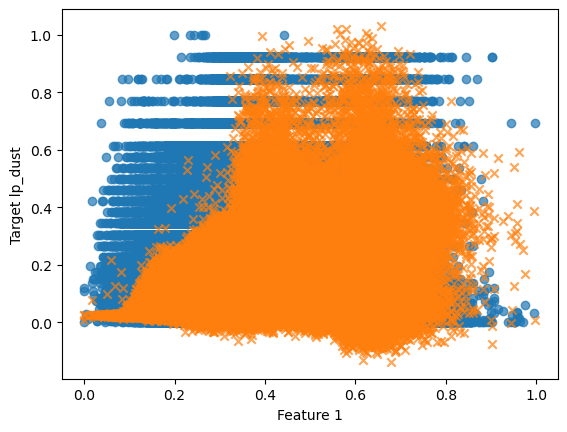

LGBMREGRESSOR(COLSAMPLE_BYTREE=0.9, MAX_DEPTH=12, N_ESTIMATORS=2000, N_JOBS=-1,
              OBJECTIVE='REGRESSION', SUBSAMPLE=0.8)


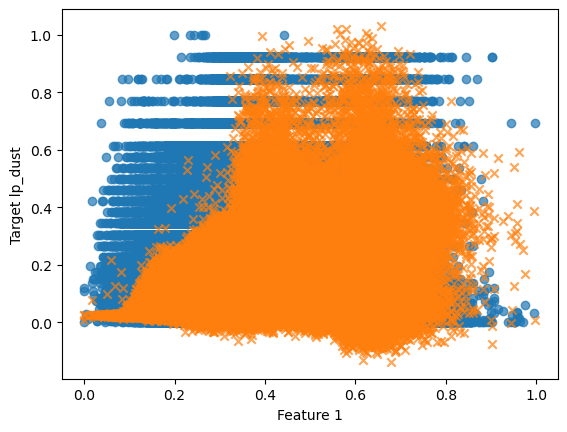

<CATBOOST.CORE.CATBOOSTREGRESSOR OBJECT AT 0X0000024CA4357850>


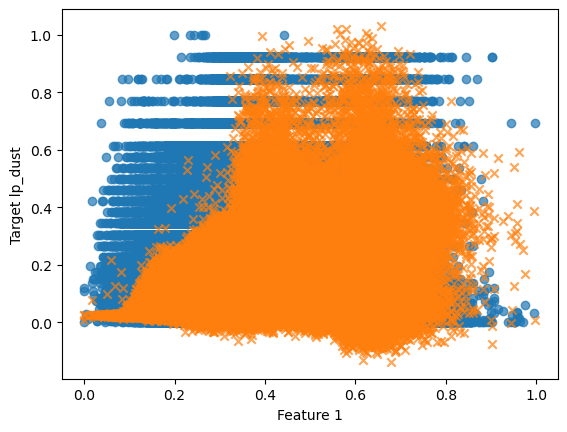

XGBREGRESSOR(BASE_SCORE=NONE, BOOSTER=NONE, CALLBACKS=NONE,
             COLSAMPLE_BYLEVEL=NONE, COLSAMPLE_BYNODE=NONE,
             COLSAMPLE_BYTREE=0.8, EARLY_STOPPING_ROUNDS=NONE,
             ENABLE_CATEGORICAL=FALSE, EVAL_METRIC=NONE, FEATURE_TYPES=NONE,
             GAMMA=NONE, GPU_ID=NONE, GROW_POLICY=NONE, IMPORTANCE_TYPE=NONE,
             INTERACTION_CONSTRAINTS=NONE, LEARNING_RATE=NONE, MAX_BIN=NONE,
             MAX_CAT_THRESHOLD=NONE, MAX_CAT_TO_ONEHOT=NONE,
             MAX_DELTA_STEP=NONE, MAX_DEPTH=9, MAX_LEAVES=NONE,
             MIN_CHILD_WEIGHT=NONE, MISSING=NAN, MONOTONE_CONSTRAINTS=NONE,
             N_ESTIMATORS=200, N_JOBS=NONE, NTHREAD=-1, NUM_PARALLEL_TREE=NONE,
             PREDICTOR=NONE, ...)


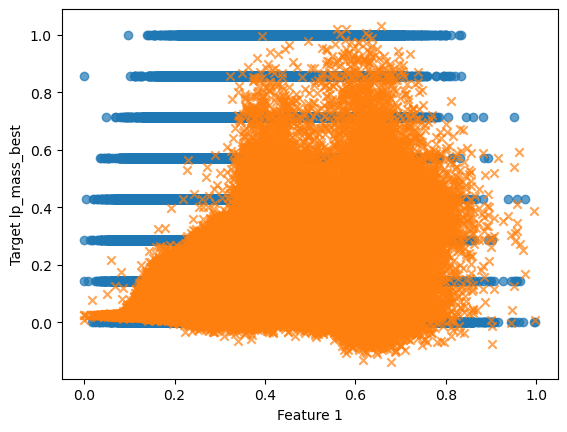

LGBMREGRESSOR(COLSAMPLE_BYTREE=0.9, MAX_DEPTH=12, N_ESTIMATORS=2000, N_JOBS=-1,
              OBJECTIVE='REGRESSION', SUBSAMPLE=0.8)


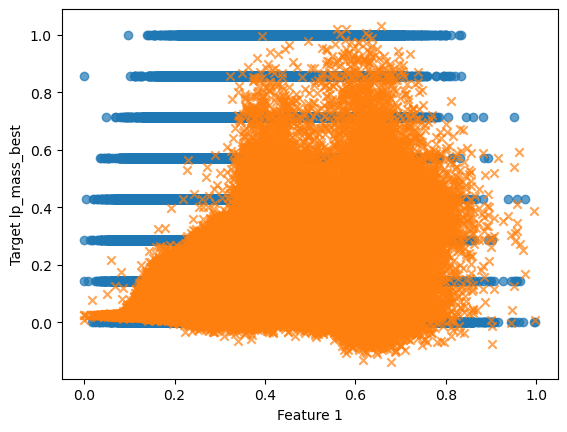

<CATBOOST.CORE.CATBOOSTREGRESSOR OBJECT AT 0X0000024CA4357850>


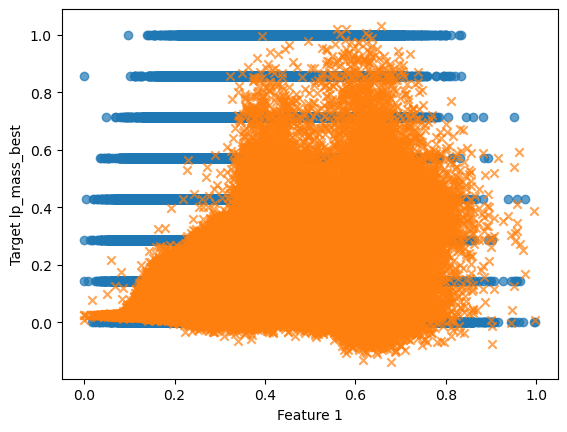

XGBREGRESSOR(BASE_SCORE=NONE, BOOSTER=NONE, CALLBACKS=NONE,
             COLSAMPLE_BYLEVEL=NONE, COLSAMPLE_BYNODE=NONE,
             COLSAMPLE_BYTREE=0.8, EARLY_STOPPING_ROUNDS=NONE,
             ENABLE_CATEGORICAL=FALSE, EVAL_METRIC=NONE, FEATURE_TYPES=NONE,
             GAMMA=NONE, GPU_ID=NONE, GROW_POLICY=NONE, IMPORTANCE_TYPE=NONE,
             INTERACTION_CONSTRAINTS=NONE, LEARNING_RATE=NONE, MAX_BIN=NONE,
             MAX_CAT_THRESHOLD=NONE, MAX_CAT_TO_ONEHOT=NONE,
             MAX_DELTA_STEP=NONE, MAX_DEPTH=9, MAX_LEAVES=NONE,
             MIN_CHILD_WEIGHT=NONE, MISSING=NAN, MONOTONE_CONSTRAINTS=NONE,
             N_ESTIMATORS=200, N_JOBS=NONE, NTHREAD=-1, NUM_PARALLEL_TREE=NONE,
             PREDICTOR=NONE, ...)


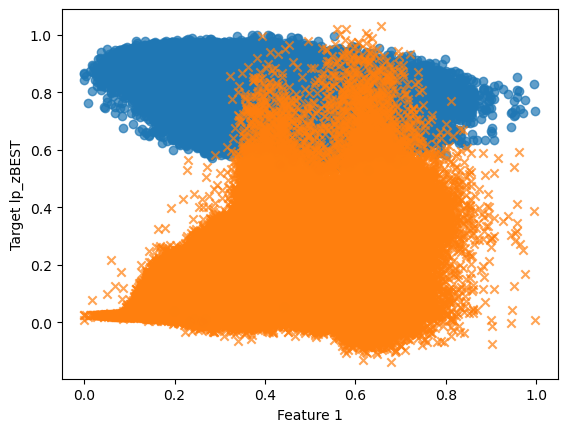

LGBMREGRESSOR(COLSAMPLE_BYTREE=0.9, MAX_DEPTH=12, N_ESTIMATORS=2000, N_JOBS=-1,
              OBJECTIVE='REGRESSION', SUBSAMPLE=0.8)


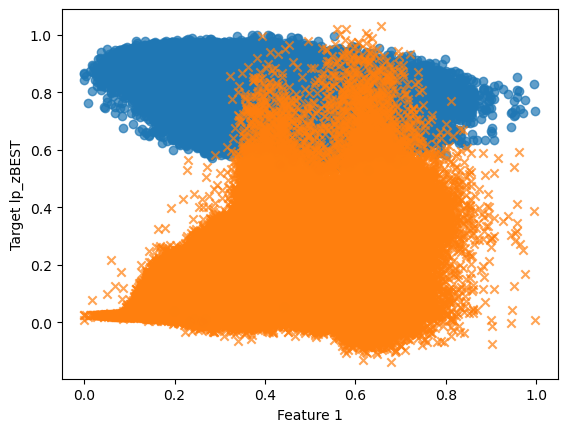

<CATBOOST.CORE.CATBOOSTREGRESSOR OBJECT AT 0X0000024CA4357850>


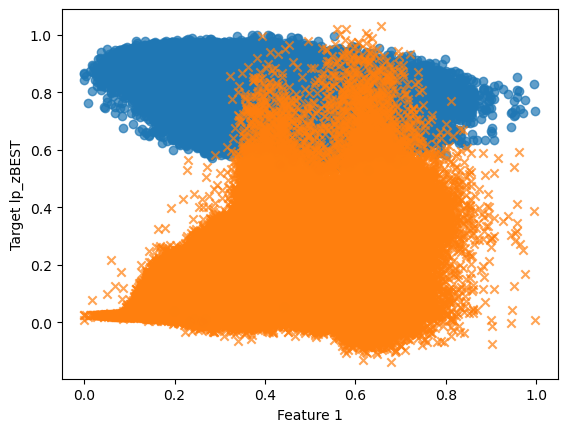

XGBREGRESSOR(BASE_SCORE=NONE, BOOSTER=NONE, CALLBACKS=NONE,
             COLSAMPLE_BYLEVEL=NONE, COLSAMPLE_BYNODE=NONE,
             COLSAMPLE_BYTREE=0.8, EARLY_STOPPING_ROUNDS=NONE,
             ENABLE_CATEGORICAL=FALSE, EVAL_METRIC=NONE, FEATURE_TYPES=NONE,
             GAMMA=NONE, GPU_ID=NONE, GROW_POLICY=NONE, IMPORTANCE_TYPE=NONE,
             INTERACTION_CONSTRAINTS=NONE, LEARNING_RATE=NONE, MAX_BIN=NONE,
             MAX_CAT_THRESHOLD=NONE, MAX_CAT_TO_ONEHOT=NONE,
             MAX_DELTA_STEP=NONE, MAX_DEPTH=9, MAX_LEAVES=NONE,
             MIN_CHILD_WEIGHT=NONE, MISSING=NAN, MONOTONE_CONSTRAINTS=NONE,
             N_ESTIMATORS=200, N_JOBS=NONE, NTHREAD=-1, NUM_PARALLEL_TREE=NONE,
             PREDICTOR=NONE, ...)


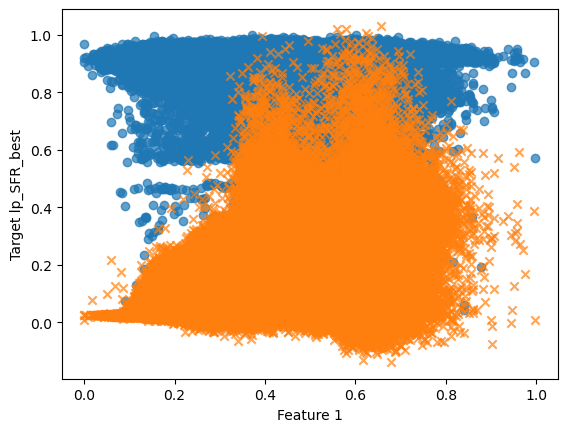

LGBMREGRESSOR(COLSAMPLE_BYTREE=0.9, MAX_DEPTH=12, N_ESTIMATORS=2000, N_JOBS=-1,
              OBJECTIVE='REGRESSION', SUBSAMPLE=0.8)


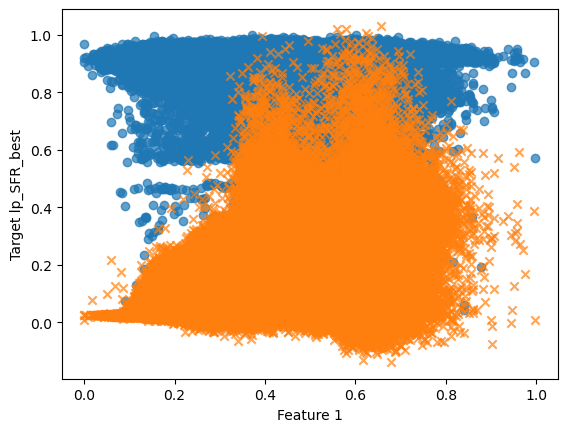

<CATBOOST.CORE.CATBOOSTREGRESSOR OBJECT AT 0X0000024CA4357850>


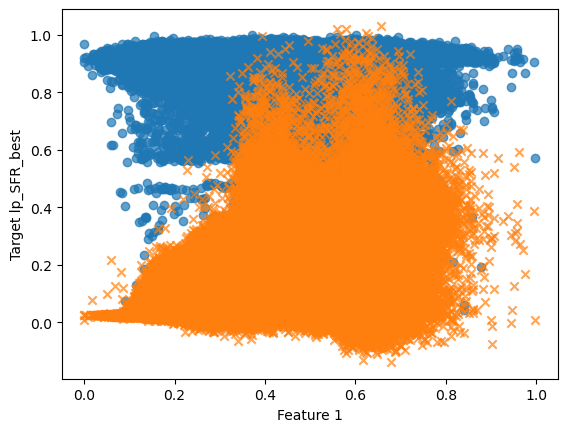

In [142]:
models = [
        XGBRegressor(
        objective='reg:squarederror', 
        n_estimators = 200,
        max_depth = 9,
        tree_method ='gpu_hist',
        nthread = -1,
        subsample = 0.8,
        colsample_bytree = 0.8
    ),
    
        LGBMRegressor(
        objective='regression',  
        n_jobs = -1,
        n_estimators = 2000,
        max_depth = 12,
        subsample = 0.8,
        colsample_bytree = 0.9
    ),
    
        CatBoostRegressor(
        loss_function ='RMSE',  
        logging_level ='Silent',
        n_estimators = 1000,
        max_depth = 11,
        task_type = "GPU"
    )
         ]

for index, feature in enumerate(labels):
    for method in models:
        print(str(method).upper())
        pipe = Pipeline([
            ("scale", StandardScaler()),
            ("model", MultiOutputRegressor(method))
        ])

        y_train_target1 = y_train.iloc[:,index]
        pred_target1 = pred[:, 0]

        plt.scatter(X_train.iloc[:, 0], y_train_target1, alpha=0.7)
        plt.scatter(X_train.iloc[:, 0], pred_target1, marker='x', alpha=0.7)
        plt.xlabel('Feature 1')
        plt.ylabel('{}'.format(feature))
        plt.show()

LP_AGE XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, nthread=-1, num_parallel_tree=None,
             predictor=None, ...)


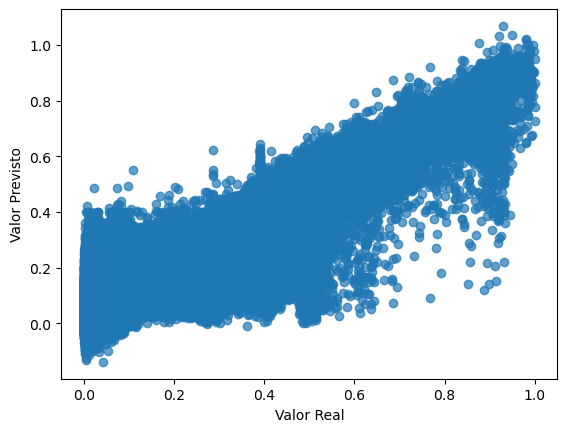

LP_AGE LGBMRegressor(colsample_bytree=0.9, max_depth=12, n_estimators=2000, n_jobs=-1,
              objective='regression', subsample=0.8)
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11220
[LightGBM] [Info] Number of data points in the train set: 990187, number of used features: 44
[LightGBM] [Info] Start training from score 0.155138



KeyboardInterrupt



In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

X = data
y = target


nan_mask = y.isna().any(axis=1)

X = X[~nan_mask]
y = y[~nan_mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1765, random_state=42)

models = [
    XGBRegressor(
        objective='reg:squarederror', 
        n_estimators=200,
        max_depth=9,
        tree_method='gpu_hist',
        nthread=-1,
        subsample=0.8,
        colsample_bytree=0.8
    ),
    LGBMRegressor(
        objective='regression',  
        n_jobs=-1,
        n_estimators=2000,
        max_depth=12,
        subsample=0.8,
        colsample_bytree=0.9
    ),
    CatBoostRegressor(
        loss_function='RMSE',  
        logging_level='Silent',
        n_estimators=1000,
        max_depth=11,
        task_type="GPU"
    )
]

for target in range(y_train.shape[1]):
    for method in models:
        print(labels[target].upper(), method)
        
        pipe = Pipeline([
            ("scale", StandardScaler()),
            ("model", MultiOutputRegressor(method))
        ])

        pipe.fit(X_train, y_train)
        pred = pipe.predict(X_train)

        y_train_target = y_train.iloc[:, target]
        pred_target = pred[:, target]

        # Plotar gráfico de dispersão para o target atual
        plt.scatter(y_train_target, pred_target, alpha=0.7)
        plt.xlabel('Valor Real')
        plt.ylabel('Valor Previsto')
        plt.show()
